In [1]:
import numpy as np
from EmbedSeg.utils.create_dicts import create_test_configs_dict
from EmbedSeg.test import begin_evaluating
from glob import glob
import tifffile
import matplotlib.pyplot as plt
from EmbedSeg.utils.visualize import visualize
import os
from matplotlib.colors import ListedColormap
import numpy as np
import warnings
warnings.filterwarnings('ignore')

/media/manan/Samsung_T51/Manan/Projects/EmbedSeg_Jupyter/EmbedSeg/test.py:51: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (False, 'checkpoint_path {} does not exist!'.format(test_configs['checkpoint_path']))


In [2]:
from datetime import date
today = date.today()
today = today.strftime("%b-%d-%Y")

### Specify the path to the evaluation images

In [3]:
data_dir = '../../../data'
project_name = 'dsb-2018'
print("Evaluation images shall be read from: {}".format(os.path.join(data_dir, project_name)))

Evaluation images shall be read from: ../../../data/dsb-2018


### Specify evaluation parameters 

Some hints:
* `tta`: Setting this to True (default) would enable **test-time augmentation**
* `ap_val`: This parameter ("average precision value") comes into action if ground truth segmentations exist for evaluation images, and allows to compare how good our predictions are versus the available ground truth segmentations.
* `seed_thresh`: This parameter ("seediness threshold") allows considering only those pixels as potential instance-centres which have a seediness score greater than `seed_thresh`
* `min_object_size`: This parameter ("minimum object size") allows considering only those predicted instances which have more interior pixels than `min_object_size` 
* `checkpoint_path`: This parameter provides the path to the trained model weights which you would like to use for evaluation
* `save_dir`: This parameter specifies the path to the prediction instances. Equal to `static` by default.
* `save_images`: If True, this saves predictions at `static/predictions/` 
* `save_results`: If True, this saves results at `static/results/`
* `normalization_factor`: Set this to either 255 (for 8-bit raw-images) or 65535 (for 16-bit instance-images). This parameter should be **set the same value** as `normalization_factor` used while creating `train_dataset_dict` and `val_dataset_dict` during training.
* `one_hot`: In case, ground truth segmentations exist for evaluation images, then set this parameter to `True` if the GT segmentations are present in a one-hot encoded style (i.e. each object is encoded as 1 in its own individual slice and 0 elsewhere) or `False`, otherwise

In the cell after this one, a `test_configs` dictionary is generated from the parameters specified here!

In [4]:
tta = True
ap_val = 0.5
seed_thresh = 0.8
min_object_size = 36
checkpoint_path = os.path.join('experiment', project_name+'-'+today, 'best_iou_model.pth')
save_dir = 'static'
save_images = True
save_results = True
normalization_factor = 255
one_hot = False
grid_y = 1024
grid_x = 1024

In [5]:
if os.path.exists(checkpoint_path):
    print("Trained model weights found at : {}".format(checkpoint_path))
else:
    print("Trained model weights were not found at the specified location!")

Trained model weights found at : experiment/dsb-2018-Dec-20-2020/best_iou_model.pth


### Create `test_configs` dictionary from the above-specified parameters

In [6]:
test_configs = create_test_configs_dict(data_dir = os.path.join(data_dir, project_name),
                                        checkpoint_path = checkpoint_path,
                                        tta = tta, 
                                        ap_val = ap_val,
                                        seed_thresh = seed_thresh, 
                                        min_object_size = min_object_size, 
                                        save_images = save_images,
                                        save_results = save_results,
                                        save_dir = save_dir,
                                        normalization_factor = normalization_factor,
                                        one_hot = one_hot,
                                        grid_y = grid_y,
                                        grid_x = grid_x,
                                        )

`test_configs` dictionary successfully created with: 
 -- evaluation images accessed from ../../../data/dsb-2018, 
 -- trained weights accessed from experiment/dsb-2018-Dec-20-2020/best_iou_model.pth, 
 -- seediness threshold set at 0.8, 
 -- output directory chosen as static


### Begin Evaluating

Setting `verbose` to True shows you Average Precision at IOU threshold specified by `ap_val` above for each individual image.

In [7]:
%matplotlib agg
begin_evaluating(test_configs, verbose = False)

2-D `test` dataloader created! Accessing data from ../../../data/dsb-2018/test/
Number of images in `test` directory is 50
Number of instances in `test` directory is 50
Number of center images in `test` directory is 0
*************************
Creating branched erfnet with [4, 1] classes


100%|██████████| 50/50 [01:37<00:00,  1.94s/it]

Mean Average Precision at IOU threshold = 0.5, is equal to 0.86203


### Load a glasbey-style color map

In [8]:
new_cmp= np.load('../../../cmaps/cmap_60.npy')
new_cmp = ListedColormap(new_cmp)

### Investigate some qualitative results

Here you can investigate some quantitative predictions. GT segmentations and predictions, if they exist, are loaded from sub-directories under `save_dir`.
Simply change `index` in the next two cells, to show the prediction for a random index.
Going clockwise from top-left is 

    * the raw-image which needs to be segmented, 
    * the corresponding ground truth instance mask, 
    * the network predicted instance mask, and 
    * (if display_embedding = True) from each object instance, 5 pixels are randomly selected (indicated with `+`), their embeddings are plotted (indicated with `.`) and the predicted margin for that object is visualized as an axis-aligned ellipse centred on the predicted - center (indicated with `x`)  for that object

In [9]:
%matplotlib inline
if(save_images):
    prediction_file_names = sorted(glob(os.path.join(save_dir,'predictions','*.tif')))
    ground_truth_file_names = sorted(glob(os.path.join(save_dir,'ground-truth','*.tif')))
    embedding_file_names = sorted(glob(os.path.join(save_dir,'embedding','*.tif')))
    image_file_names = sorted(glob(os.path.join(data_dir, project_name, 'test', 'images','*.tif')))

Image filename is 7d40ea6ead1bec903f26d9046d291aedcb12a584b4d3b337ea252b34c7d86072.tif and index is 24


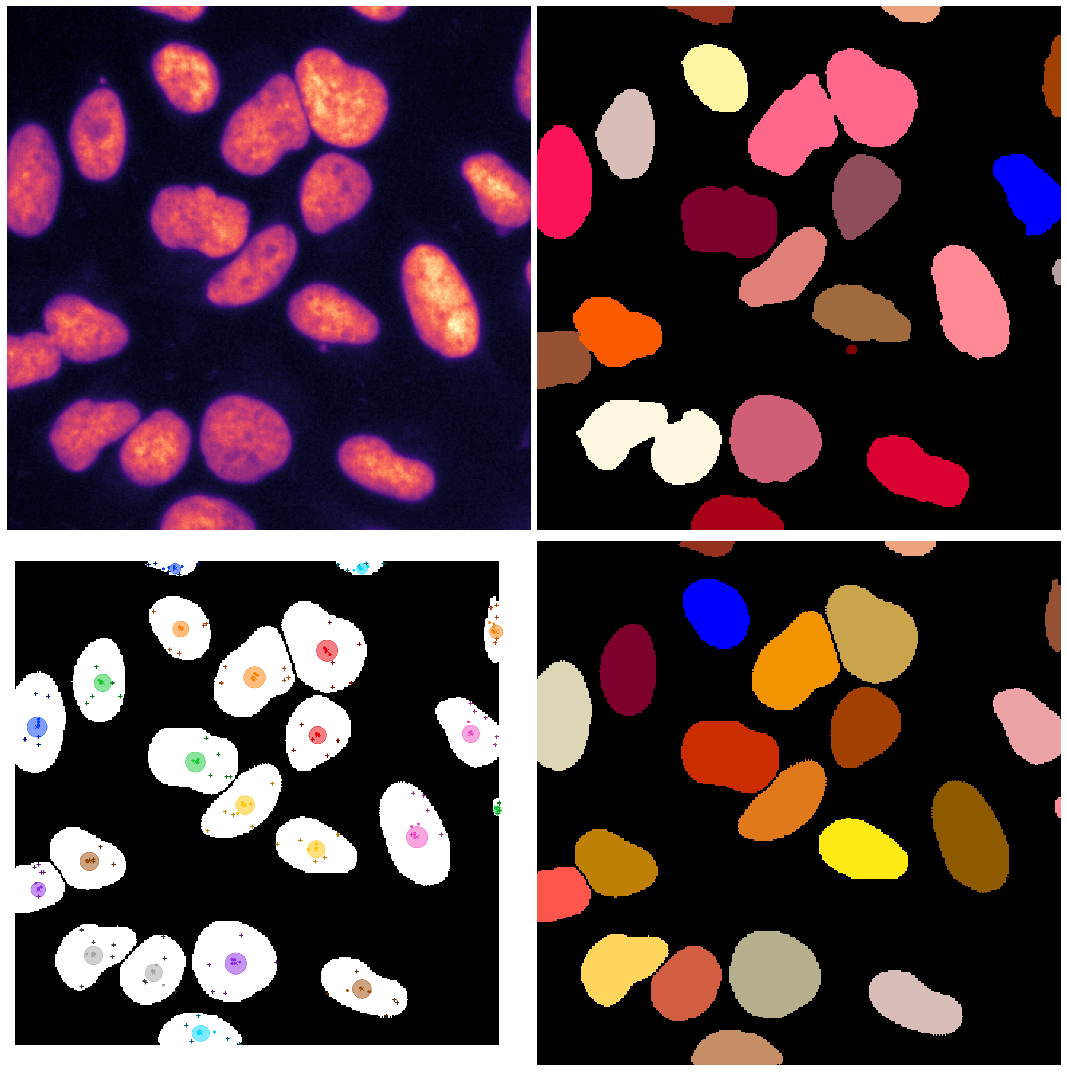

In [10]:
if(save_images):
    index = 24 
    print("Image filename is {} and index is {}".format(os.path.basename(image_file_names[index]), index))
    prediction = tifffile.imread(prediction_file_names[index])
    ground_truth = tifffile.imread(ground_truth_file_names[index])
    image = tifffile.imread(image_file_names[index])
    embedding = tifffile.imread(embedding_file_names[index])
    visualize(image = image, prediction = prediction, ground_truth = ground_truth, embedding = embedding, new_cmp = new_cmp)

Image filename is 89be66f88612aae541f5843abcd9c015832b5d6c54a28103b3019f7f38df8a6d.tif and index is 26


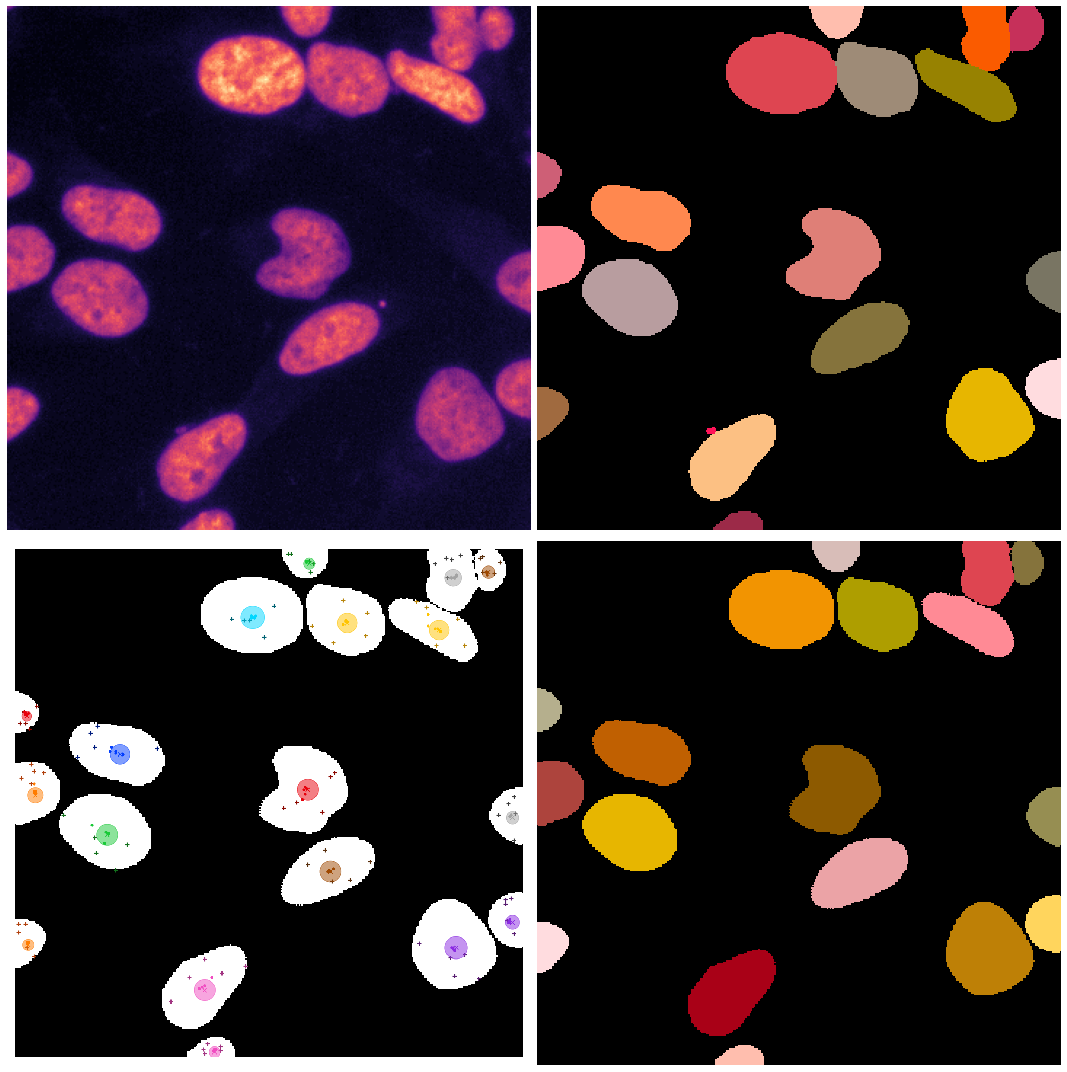

In [11]:
if (save_images):
    index = 26
    print("Image filename is {} and index is {}".format(os.path.basename(image_file_names[index]), index))
    prediction = tifffile.imread(prediction_file_names[index])
    ground_truth = tifffile.imread(ground_truth_file_names[index])
    image = tifffile.imread(image_file_names[index])
    embedding = tifffile.imread(embedding_file_names[index])
    visualize(image = image, prediction = prediction, ground_truth = ground_truth, embedding = embedding, new_cmp = new_cmp)